In [ ]:
import nidaqmx as ni
import nidaqmx.constants as cst
import matplotlib.pyplot as plt
from nidaqmx.stream_readers import AnalogMultiChannelReader, CounterReader
import numpy as np
import time

In [101]:
'''general parameters for test 1 - 2 '''

# parameters of clock
_device_name = 'Dev3'
clk_terminal = 'ctr0'
_sample_rate = 10 # this should be the same as the externel trigger rate
_frame_size = 100
test_time = _frame_size / _sample_rate
_physical_sample_clock_output = 'PFI12'
sampleMode_clk = cst.AcquisitionType.FINITE

# parameters of analog channels
analog_channels = ('ai0', 'ai1')
_adc_voltage_range = (-10, 10)
_rw_timeout = 20
external_sample_clock_source = 'PFI0'
sampleMode_ai = cst.AcquisitionType.FINITE

# parameters of digital channels
# Here we donnot use any digital channel

Reset device Dev3.
Acquisition Finished


c:\Users\pi3-pc12\miniconda3\envs\qudi-env\lib\site-packages\nidaqmx\_library_interpreter.py:6034: DaqWarning: 
Warning 200010 occurred.

Finite acquisition or generation has been stopped before the requested number of samples were acquired or generated.
  warnings.warn(DaqWarning(error_string, error_code))


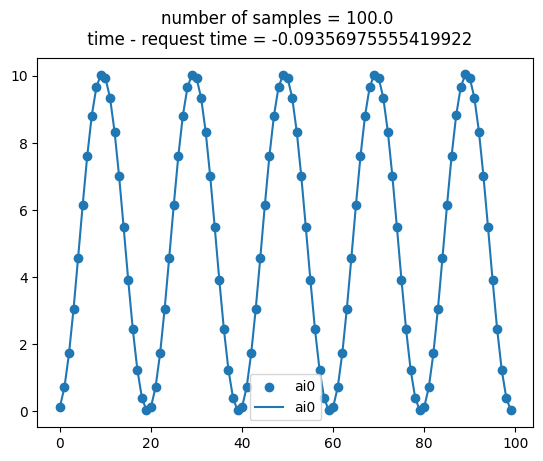

In [103]:
'''test 1: one trigger corresponds one sample
    with Internel trigger'''

# 0. reset device
_device_handle = ni.system.Device(_device_name)
try:
    _device_handle.reset_device()
    print('Reset device {0}.'.format(_device_name))
except ni.DaqError:
    print('Could not reset NI device {0}'.format(_device_name))

# 1. configerate the clock
clk = ni.Task()
clk.co_channels.add_co_pulse_chan_freq(
                    '/{0}/{1}'.format(_device_name, clk_terminal),
                    freq=_sample_rate,
                    idle_state=ni.constants.Level.LOW)
clk.timing.cfg_implicit_timing(
                    sample_mode=sampleMode_clk,
                    samps_per_chan=_frame_size + 1)

# TODO here what if samps_per_chan = _frame_size + 1 or only _frame_size  ???

clk.control(ni.constants.TaskMode.TASK_RESERVE)
clock_channel = '/{0}InternalOutput'.format(clk.channel_names[0])
ni.system.System().connect_terms(source_terminal=clock_channel,
                                            destination_terminal='/{0}/{1}'.format(
                                            _device_name, _physical_sample_clock_output))

# 2. configerate the analog channel
ai = ni.Task()
ai_ch_str = ','.join(['/{0}/{1}'.format(_device_name, c) for c in analog_channels])
ai.ai_channels.add_ai_voltage_chan(ai_ch_str,
                                    max_val=max(_adc_voltage_range),
                                    min_val=min(_adc_voltage_range))
ai.timing.cfg_samp_clk_timing(_sample_rate,
                                    source=clock_channel,
                                    active_edge=ni.constants.Edge.RISING,
                                    sample_mode=sampleMode_ai,
                                    samps_per_chan=_frame_size)
# If sample_mode is CONTINUOUS_SAMPLES, 
# NI-DAQmx uses this value (samps_per_chan) to determine the buffer size.
# This describtion only fit for cfg_samp_clk_timin !!!
ai.control(ni.constants.TaskMode.TASK_RESERVE)
_ai_reader = AnalogMultiChannelReader(ai.in_stream)
_ai_reader.verify_array_shape = False

# 3. start buffered acquisition
begin_time = time.time()
try:
    ai.start()
except ni.DaqError:
    print('schief gehen bei Starten von ai task')

try:
    clk.start()
except ni.DaqError:
    print('schief gehen bei Starten von clk task')

# 4. get buffered samples
data = dict()
number_of_samples = _frame_size
try:
    data_buffer = np.zeros(number_of_samples* len(analog_channels))
    read_samples = _ai_reader.read_many_sample(
        data_buffer,
        number_of_samples_per_channel=number_of_samples,
        timeout=_rw_timeout)
    # if read_samples != number_of_samples:
    #     return data
    for num, ai_channel in enumerate(analog_channels):
        data[ai_channel] = data_buffer[num * number_of_samples:(num + 1) * number_of_samples]
except ni.DaqError:
    print('Getting samples from streamer failed.')

# 5. stop buffered acquisition
try:
    ai.stop()
    ai.close()
except ni.DaqError:
    print('Error while trying to terminate ai task.')

try:
    clk.stop()
    clk.close()
except ni.DaqError:
    print('Error while trying to terminate clk task.')
end_time = time.time()

# 6. plot
print('Acquisition Finished')
plt.figure()
plt.scatter(np.arange(start = 0, stop = len(data['ai0']), step = 1),data['ai0'],  label = 'ai0')
# plt.scatter(np.arange(start = 0, stop = len(data['ai1']), step = 1),data['ai1'],  label = 'ai1')
plt.plot(data['ai0'],label = 'ai0')
plt.suptitle('number of samples = {0}\n time - request time = {1}'.format(
    len(data_buffer)/2, end_time - begin_time - _frame_size/_sample_rate))
plt.legend()
plt.show()




Reset device Dev3.
Acquisition Finished


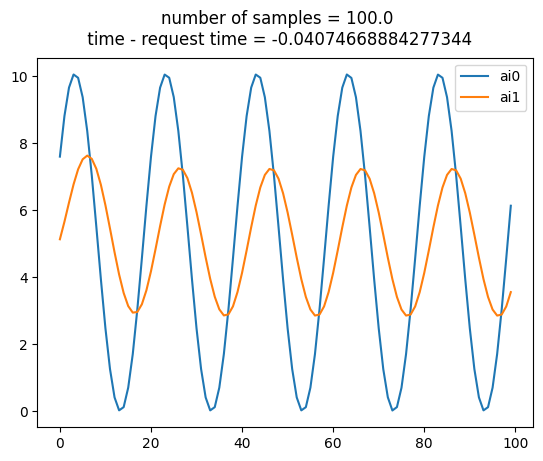

In [104]:
'''test 2: one trigger corresponds one sample
    with Externel trigger'''

# 0. reset device
_device_handle = ni.system.Device(_device_name)
try:
    _device_handle.reset_device()
    print('Reset device {0}.'.format(_device_name))
except ni.DaqError:
    print('Could not reset NI device {0}'.format(_device_name))
    
# 1. configerate the clock
# not necessary deu to externel clk

# 2. configerate the analog channel
ai = ni.Task()
ai_ch_str = ','.join(['/{0}/{1}'.format(_device_name, c) for c in analog_channels])
ai.ai_channels.add_ai_voltage_chan(ai_ch_str,
                                    max_val=max(_adc_voltage_range),
                                    min_val=min(_adc_voltage_range))
ai.timing.cfg_samp_clk_timing(_sample_rate,
                                    source= '/{0}/{1}'.format(_device_name, external_sample_clock_source),
                                    active_edge=ni.constants.Edge.RISING,
                                    sample_mode=sampleMode_ai,
                                    samps_per_chan=_frame_size)
# If sample_mode is CONTINUOUS_SAMPLES, 
# NI-DAQmx uses this value (samps_per_chan) to determine the buffer size.
ai.control(ni.constants.TaskMode.TASK_RESERVE)
_ai_reader = AnalogMultiChannelReader(ai.in_stream)
_ai_reader.verify_array_shape = False

# 3. start buffered acquisition
begin_time = time.time()
try:
    ai.start()
except ni.DaqError:
    print('schief gehen bei Starten von ai task')

# 4. get buffered samples
data = dict()
number_of_samples = _frame_size
try:
    data_buffer = np.zeros(number_of_samples * len(analog_channels))
    read_samples = _ai_reader.read_many_sample(
        data_buffer,
        number_of_samples_per_channel=number_of_samples,
        timeout=_rw_timeout)
    # if read_samples != number_of_samples:
    #     return data
    for num, ai_channel in enumerate(analog_channels):
        data[ai_channel] = data_buffer[num * number_of_samples:(num + 1) * number_of_samples]
except ni.DaqError:
    print('Getting samples from streamer failed.')

# 5. stop buffered acquisition
try:
    ai.stop()
    ai.close()
except ni.DaqError:
    print('Error while trying to terminate ai task.')

end_time = time.time()

# 6. plot
print('Acquisition Finished')
plt.figure()
plt.plot(data['ai0'],label = 'ai0')
plt.plot(data['ai1'],label = 'ai1')
plt.suptitle('number of samples = {0}\n time - request time = {1}'.format(
    len(data_buffer)/2, end_time - begin_time - _frame_size/_sample_rate))
plt.legend()
plt.show()


In [142]:
'''general parameters for test 3 - 4 '''

# parameters of clock
_device_name = 'Dev3'
clk_terminal = 'ctr0'
counter_terminal = 'ctr1'
_clk_rate = 2e3
_clk_size = 10
runtime = _clk_size / _clk_rate
_sample_rate = 1000
_sample_time = 0.99 # must smaller than the peoriod of the trigger

_frame_size = int(_sample_rate * _sample_time)
_physical_sample_clock_output = 'PFI12'
_physical_counter_clock_output = 'PFI12'
_physical_trigger_clock_output = 'PFI13'
sampleMode_clk = cst.AcquisitionType.FINITE

# parameters of analog channels
analog_channels = 'ai0'
_adc_voltage_range = (-10, 10)
_rw_timeout = 20
num_pusles = 5
external_sample_clock_source = 'PFI0'
sampleMode_ai = cst.AcquisitionType.CONTINUOUS
diffTerminal = cst.TerminalConfiguration.RSE

# parameters of digital channels
# Here we donnot use any digital channel

Reset device Dev3.
Acquisition Finished


c:\Users\pi3-pc12\miniconda3\envs\qudi-env\lib\site-packages\nidaqmx\_library_interpreter.py:6034: DaqWarning: 
Warning 200010 occurred.

Finite acquisition or generation has been stopped before the requested number of samples were acquired or generated.
  warnings.warn(DaqWarning(error_string, error_code))


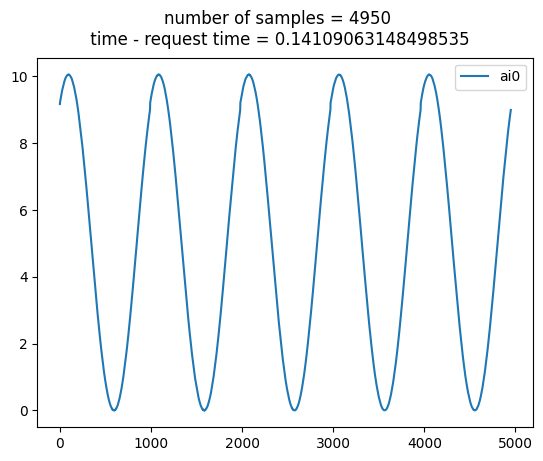

In [88]:
'''test 3: one trigger corresponds multiple samples
    with Internel trigger'''

'''
ATTENTION !!!!
Test 3 cannot be realized. Because Nidaqmx doesn't support 2 clk/counter task at the same time! 
So when we wanna use multiple trigger mode, we can only use a externel trigger as our 
main trigger. The counter task will be used to follow the trigger and drive the ai channel.
'''

# 0. reset device
_device_handle = ni.system.Device(_device_name)
try:
    _device_handle.reset_device()
    print('Reset device {0}.'.format(_device_name))
except ni.DaqError:
    print('Could not reset NI device {0}'.format(_device_name))
    
# 1. configerate the clock (2 internel clk necessary!)
counter = ni.Task()
counter.co_channels.add_co_pulse_chan_freq(
                    '/{0}/{1}'.format(_device_name, counter_terminal),
                    freq=_clk_rate,
                    idle_state=ni.constants.Level.LOW)
counter.timing.cfg_implicit_timing(
                    sample_mode=sampleMode_clk, 
                    samps_per_chan=_clk_size)
counter.control(ni.constants.TaskMode.TASK_RESERVE)
clock_channel = '/{0}InternalOutput'.format(counter.channel_names[0])
ni.system.System().connect_terms(source_terminal=clock_channel,
                                            destination_terminal='/{0}/{1}'.format(
                                            _device_name, _physical_trigger_clock_output))
clk = ni.Task()
clk.co_channels.add_co_pulse_chan_freq(
                    '/{0}/{1}'.format(_device_name, clk_terminal),
                    freq=_sample_rate,
                    idle_state=ni.constants.Level.LOW)
clk.timing.cfg_implicit_timing(
                    sample_mode=sampleMode_clk,
                    samps_per_chan=_frame_size)
clk.triggers.start_trigger.cfg_dig_edge_start_trig(
                    '/{0}/{1}'.format(_device_name, 
                    external_sample_clock_source), 
                    trigger_edge=cst.Edge.RISING)
clk.triggers.start_trigger.retriggerable = True
clk.control(ni.constants.TaskMode.TASK_RESERVE)

# 2. configerate the analog channel
ai = ni.Task()
ai.ai_channels.add_ai_voltage_chan('/{0}/{1}'.format(_device_name, analog_channels),
                                    terminal_config=diffTerminal,
                                    max_val=max(_adc_voltage_range),
                                    min_val=min(_adc_voltage_range))
ai.ai_channels.ai_impedance = cst.Impedance1.FIFTY_OHMS
ai.timing.cfg_samp_clk_timing(_sample_rate,
                                    source='/{0}/{1}'.format(_device_name, 
                                            _physical_counter_clock_output),
                                    active_edge=ni.constants.Edge.RISING,
                                    sample_mode=sampleMode_ai,
                                    samps_per_chan=_frame_size)
# If sample_mode is CONTINUOUS_SAMPLES, 
# NI-DAQmx uses this value (samps_per_chan) to determine the buffer size.
# This describtion only fit for cfg_samp_clk_timin !!!
ai.control(ni.constants.TaskMode.TASK_RESERVE)

# 3. start buffered acquisition
begin_time = time.time()
try:
    ai.start()
except ni.DaqError:
    print('schief gehen bei Starten von ai task')

try:
    clk.start()
except ni.DaqError:
    print('schief gehen bei Starten von clk task')

# 4. get buffered samples
data = list()
number_of_samples = _frame_size
try:
    data = ai.read(
        number_of_samples_per_channel = num_pusles*_frame_size, 
        timeout=_rw_timeout)
except ni.DaqError:
    print('Getting samples from streamer failed.')

# 5. stop buffered acquisition
try:
    ai.stop()
    ai.close()
except ni.DaqError:
    print('Error while trying to terminate ai task.')

try:
    clk.stop()
    clk.close()
except ni.DaqError:
    print('Error while trying to terminate clk task.')
end_time = time.time()

# 6. plot
print('Acquisition Finished')
plt.figure()
plt.plot(data,label = 'ai0')
# plt.scatter(np.arange(start = 0, stop = len(data), step = 1),data,  label = 'ai0')
plt.suptitle('number of samples = {0}\n time - request time = {1}'.format(
    len(data), end_time - begin_time - num_pusles/_clk_rate))
plt.legend()
plt.show()



Reset device Dev3.
Getting samples from streamer failed.
Acquisition Finished


c:\Users\pi3-pc12\miniconda3\envs\qudi-env\lib\site-packages\nidaqmx\_library_interpreter.py:6034: DaqWarning: 
Warning 200010 occurred.

Finite acquisition or generation has been stopped before the requested number of samples were acquired or generated.
  warnings.warn(DaqWarning(error_string, error_code))


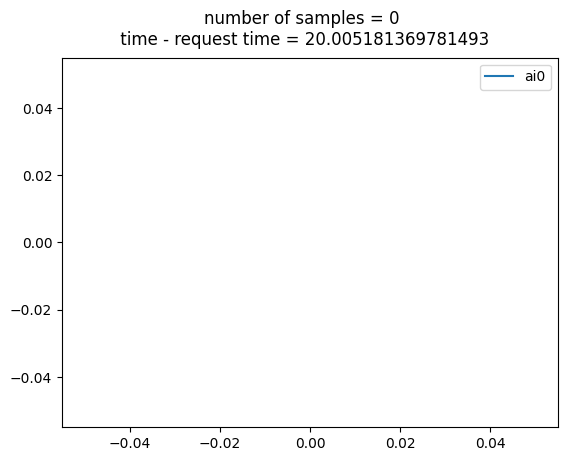

In [143]:
'''test 4: one trigger corresponds multiple samples
    with Externel trigger'''

# 0. reset device
_device_handle = ni.system.Device(_device_name)
try:
    _device_handle.reset_device()
    print('Reset device {0}.'.format(_device_name))
except ni.DaqError:
    print('Could not reset NI device {0}'.format(_device_name))

# 1. configerate the clock
clk = ni.Task()
clk.co_channels.add_co_pulse_chan_freq(
                    '/{0}/{1}'.format(_device_name, clk_terminal),
                    freq=_sample_rate,
                    idle_state=ni.constants.Level.LOW)
clk.timing.cfg_implicit_timing(
                    sample_mode=sampleMode_clk,
                    samps_per_chan=_frame_size)
clk.triggers.start_trigger.cfg_dig_edge_start_trig(
                    '/{0}/{1}'.format(_device_name, 
                    external_sample_clock_source), 
                    trigger_edge=cst.Edge.RISING)
clk.triggers.start_trigger.retriggerable = True
clk.control(ni.constants.TaskMode.TASK_RESERVE)

# 2. configerate the analog channel
ai = ni.Task()
ai.ai_channels.add_ai_voltage_chan('/{0}/{1}'.format(_device_name, analog_channels),
                                    terminal_config=diffTerminal,
                                    max_val=max(_adc_voltage_range),
                                    min_val=min(_adc_voltage_range))
ai.ai_channels.ai_impedance = cst.Impedance1.FIFTY_OHMS
ai.timing.cfg_samp_clk_timing(_sample_rate,
                                    source='/{0}/{1}'.format(_device_name, 
                                            _physical_sample_clock_output),
                                    active_edge=ni.constants.Edge.RISING,
                                    sample_mode=sampleMode_ai,
                                    samps_per_chan=_frame_size)
# If sample_mode is CONTINUOUS_SAMPLES, 
# NI-DAQmx uses this value (samps_per_chan) to determine the buffer size.
# This describtion only fit for cfg_samp_clk_timin !!!
ai.control(ni.constants.TaskMode.TASK_RESERVE)

# 3. start buffered acquisition
begin_time = time.time()
try:
    ai.start()
except ni.DaqError:
    print('schief gehen bei Starten von ai task')

try:
    clk.start()
except ni.DaqError:
    print('schief gehen bei Starten von clk task')

# 4. get buffered samples
data = list()
number_of_samples = _frame_size
try:
    data = ai.read(
        number_of_samples_per_channel = num_pusles*_frame_size, 
        timeout=_rw_timeout)
except ni.DaqError:
    print('Getting samples from streamer failed.')

# 5. stop buffered acquisition
try:
    ai.stop()
    ai.close()
except ni.DaqError:
    print('Error while trying to terminate ai task.')

try:
    clk.stop()
    clk.close()
except ni.DaqError:
    print('Error while trying to terminate clk task.')
end_time = time.time()

# 6. plot
print('Acquisition Finished')
plt.figure()
plt.plot(data,label = 'ai0')
# plt.scatter(np.arange(start = 0, stop = len(data), step = 1),data,  label = 'ai0')
plt.suptitle('number of samples = {0}\n time - request time = {1}'.format(
    len(data), end_time - begin_time - num_pusles/_clk_rate))
plt.legend()
plt.show()

Reset device Dev3.
Getting samples from streamer failed.
Acquisition Finished


c:\Users\pi3-pc12\miniconda3\envs\qudi-env\lib\site-packages\nidaqmx\_library_interpreter.py:6034: DaqWarning: 
Warning 200010 occurred.

Finite acquisition or generation has been stopped before the requested number of samples were acquired or generated.
  warnings.warn(DaqWarning(error_string, error_code))


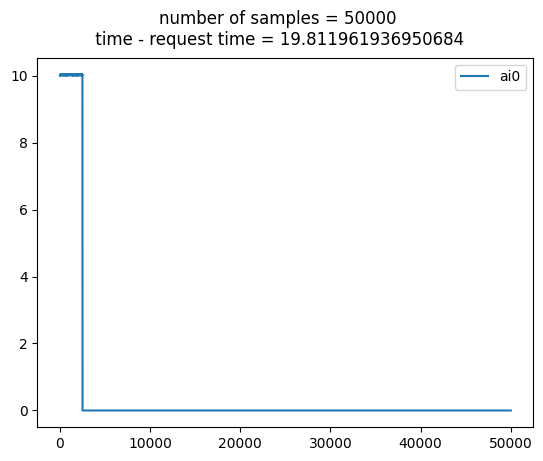

In [141]:
'''test 5: one trigger corresponds multiple samples
    with Externel trigger
    with another ai_reading method
    '''

# 0. reset device
_device_handle = ni.system.Device(_device_name)
try:
    _device_handle.reset_device()
    print('Reset device {0}.'.format(_device_name))
except ni.DaqError:
    print('Could not reset NI device {0}'.format(_device_name))

# 1. configerate the clock
clk = ni.Task()
clk.co_channels.add_co_pulse_chan_freq(
                    '/{0}/{1}'.format(_device_name, clk_terminal),
                    freq=_sample_rate,
                    idle_state=ni.constants.Level.LOW)
clk.timing.cfg_implicit_timing(
                    sample_mode=sampleMode_clk,
                    samps_per_chan=_frame_size)
clk.triggers.start_trigger.cfg_dig_edge_start_trig(
                    '/{0}/{1}'.format(_device_name, 
                    external_sample_clock_source), 
                    trigger_edge=cst.Edge.RISING)
clk.triggers.start_trigger.retriggerable = True
clk.control(ni.constants.TaskMode.TASK_RESERVE)

# 2. configerate the analog channel
ai = ni.Task()
ai.ai_channels.add_ai_voltage_chan('/{0}/{1}'.format(_device_name, analog_channels),
                                    terminal_config=diffTerminal,
                                    max_val=max(_adc_voltage_range),
                                    min_val=min(_adc_voltage_range))
ai.ai_channels.ai_impedance = cst.Impedance1.FIFTY_OHMS
ai.timing.cfg_samp_clk_timing(_sample_rate,
                                    source='/{0}/{1}'.format(_device_name, 
                                            _physical_sample_clock_output),
                                    active_edge=ni.constants.Edge.RISING,
                                    sample_mode=sampleMode_ai,
                                    samps_per_chan=_frame_size)
# If sample_mode is CONTINUOUS_SAMPLES, 
# NI-DAQmx uses this value (samps_per_chan) to determine the buffer size.
# This describtion only fit for cfg_samp_clk_timin !!!
ai.control(ni.constants.TaskMode.TASK_RESERVE)

try:
    ai_reader = AnalogMultiChannelReader(ai.in_stream)
    ai_reader.verify_array_shape = False
except ni.DaqError:
    print('schief gehen bei Configuration des ai_readers')

# 3. start buffered acquisition
begin_time = time.time()
try:
    ai.start()
except ni.DaqError:
    print('schief gehen bei Starten von ai task')

try:
    clk.start()
except ni.DaqError:
    print('schief gehen bei Starten von clk task')

# 4. get buffered samples
data = np.zeros(_frame_size * num_pusles)
try:
    read_samples = ai_reader.read_many_sample(
        data,
        number_of_samples_per_channel = num_pusles*_frame_size, 
        timeout=_rw_timeout)
except ni.DaqError:
    print('Getting samples from streamer failed.')

# 5. stop buffered acquisition
try:
    ai.stop()
    ai.close()
except ni.DaqError:
    print('Error while trying to terminate ai task.')

try:
    clk.stop()
    clk.close()
except ni.DaqError:
    print('Error while trying to terminate clk task.')
end_time = time.time()

# 6. plot
print('Acquisition Finished')
plt.figure()
plt.plot(data,label = 'ai0')
# plt.scatter(np.arange(start = 0, stop = len(data), step = 1),data,  label = 'ai0')
plt.suptitle('number of samples = {0}\n time - request time = {1}'.format(
    len(data), end_time - begin_time - num_pusles/_clk_rate))
plt.legend()
plt.show()